# 库文件

In [138]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
from collections import defaultdict

# 设定路径

In [139]:
train_filepath = "train.csv"
test_filepath = "test.csv"

# 读取样本文件和测试文件

In [140]:
class clearinfo:
    def __init__(self,train_filepath,test_filepath):
        self.train_filepath = train_filepath
        self.test_filepath = test_filepath
    def getinfo_train(self):
        train_data = pd.read_csv(self.train_filepath,header=0)
        return train_data
    def getinfo_test(self):
        test_data = pd.read_csv(self.test_filepath,header=0)
        return test_data
info = clearinfo(train_filepath,test_filepath)

In [141]:
df_train = info.getinfo_train()
df_test  = info.getinfo_test()

In [142]:
df_train.drop('date',axis=1,inplace=True)
df_test.drop('date',axis=1,inplace=True)

# User与Business标号

In [144]:
U_id  = {}
id_U  = {}
B_id  = {}
id_B  = {}

In [146]:
def grade(df):
    global U_id,id_U,B_id,id_B
    for i in range(0,len(df)):
        if df['user_id'][i] not in U_id:
            U_id[df['user_id'][i]]=i
            id_U[i]=df['user_id'][i]
            df['user_id'][i]=i
        else:
            df['user_id'][i] = U_id[df['user_id'][i]]
        if df['business_id'][i] not in B_id:
            B_id[df['business_id'][i]]=i
            id_B[i]=df['business_id'][i]
            df['business_id'][i]=i
        else:
            df['business_id'][i]=B_id[df['business_id'][i]]
    return df
tr_grade = grade(df_train)

<ipython-input-146-a8185f0b7380>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_id'][i]=i
<ipython-input-146-a8185f0b7380>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['business_id'][i]=i
<ipython-input-146-a8185f0b7380>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['business_id'][i]=B_id[df['business_id'][i]]
<ipython-input-146-a8185f0b7380>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [148]:
def grade_te(df):
    for i in range(0,len(df)):
        df['user_id'][i]=U_id[df['user_id'][i]]
        df['business_id'][i]=B_id[df['business_id'][i]]
    return df
te_grade = grade_te(df_test)

# 实现隐变量模型类

In [155]:
class LF:
    def __init__(self,df,k,norm):
        #先生成一个User_Business评分矩阵，这里先构建一个全0矩阵，稍后填充
        self.UB = np.mat(np.zeros((int(df[['user_id']].max())+1,int(df[['business_id']].max())+1))) 
        #找到对B评论的所有U，和U评论的所有B
        self.B_U = defaultdict(set)
        self.U_B = defaultdict(set)
        for i in range(0,len(df)):
            user,business,stars =int(df['user_id'][i]),int(df['business_id'][i]),df['stars'][i]   
            self.UB[user,business]=stars
            self.B_U[business].add(user)
            self.U_B[user].add(business)
        self.k= k  #选取的k
        self.norm = norm
        #构建预测评分矩阵
        self.User =  np.mat(np.random.uniform(sqrt(1/k),sqrt(5/k),(self.UB.shape[0],k)))
        self.Business =  np.mat(np.random.uniform(sqrt(1/k),sqrt(5/k),(self.UB.shape[1],k)))
        
    #定义损失函数
    def loss(self):
        ret = self.norm * (np.sum(np.square(self.User)) + np.sum(np.square(self.Business)))
        #User * Business 的转置
        pred = self.User * self.Business.T 
        for i in range(self.UB.shape[0]):
            for j in range(self.UB.shape[1]):
                if self.UB[i,j] != 0:
                    ret += (self.UB[i,j] - pred[i,j]) ** 2
        return ret
    
    #梯度下降
    #lr学习率，maxd最大迭代深度，th阈值
    def grad_fit(self,lr = 0.01,maxd = 15,th = 100): 
        d = 0
        x = []
        loss_val = []
        train_score = []
        val_score = []
        while d < maxd and self.loss() > th:
            for uid in range(1,self.UB.shape[0]):
                grad = 2 * self.norm * self.User[uid]
                for bid in self.U_B[uid]:
                    grad = grad - 2 * (self.UB[uid,bid] - self.User[uid] * self.Business[bid].T) * self.Business[bid] 
                self.User[uid] = self.User[uid] - lr * grad
            for bid in range(1,self.UB.shape[1]):
                grad = 2 * self.norm * self.Business[bid]
                for uid in self.B_U[bid]:
                    grad = grad - 2 * (self.UB[uid,bid] - self.User[uid] * self.Business[bid].T) * self.User[uid] 
                self.Business[bid] = self.Business[bid] - lr * grad
            x.append(d)
            loss_val.append(self.loss())
            train_score.append(self.RMSE_score(tr_grade))
            val_score.append(self.RMSE_score(tr_grade))
            d += 1
        return x,loss_val,train_score,val_score
    
    #交替最小二乘法
    #maxd最大迭代深度，th阈值
    def als_fit(self,maxd = 25,th = 100): 
        d = 0
        x = []
        loss_val = []
        train_score = []
        val_score = []
        while d < maxd and self.loss() > th:
            for uid in range(1,self.UB.shape[0]):
                left = np.mat(np.zeros((1,self.k)))
                right = np.mat(np.zeros((self.k,self.k)))
                for bid in self.U_B[uid]:
                    right += self.Business[bid].T * self.Business[bid]
                    left += self.UB[uid,bid] * self.Business[bid]
                right += self.norm * np.identity(self.k)
                if abs(np.linalg.det(right)) < 1e-6:
                    self.User[uid] = left * np.linalg.pinv(right + self.norm * np.identity(self.k)) 
                else:
                    self.User[uid] = left * np.linalg.inv(right + self.norm * np.identity(self.k))  
                #采用moore-penrose伪逆
            for bid in range(1,self.UB.shape[1]):
                left = np.mat(np.zeros((1,self.k)))
                right = np.mat(np.zeros((self.k,self.k)))
                for uid in self.B_U[bid]:
                    right += self.User[uid].T * self.User[uid]
                    left += self.UB[uid,bid] * self.User[uid]
                right += self.norm * np.identity(self.k)
                if abs(np.linalg.det(right)) < 1e-6:
                    self.Business[bid] = left * np.linalg.pinv(right + self.norm * np.identity(self.k)) 
                else:
                    self.Business[bid] = left * np.linalg.inv(right + self.norm * np.identity(self.k))  
                #同上，采用moore-penrose伪逆
            x.append(d)
            loss_val.append(self.loss())
            train_score.append(self.RMSE_score(tr_grade))
            val_score.append(self.RMSE_score(tr_grade))
            d += 1
        return x,loss_val,train_score,val_score
    
    #计算评价指标RMSE
    def RMSE_score(self,df):
        r = 0
        n = 0
        pred = self.User * self.Business.T
        for i in range(0,len(df)):
            uid,bid,stars =int(df['user_id'][i]),int(df['business_id'][i]),df['stars'][i] 
            if uid < pred.shape[0] and bid < pred.shape[1]:
                r += (pred[uid,bid] - stars) ** 2
                n += 1
        return sqrt(r/n)
    
    #预测结果
    def pred(self,df_test):
        ans = []
        pred = self.User* self.Business.T
        for idx,row in df_test.iterrows():
            uid,bid = int(row['user_id']),int(row['business_id'])
            if uid < pred.shape[0] and bid < pred.shape[1]:
                ans.append(pred[uid,bid])
            else:
                ans.append(3)
        return ans

# 生成隐变量模型

In [156]:
model = LF(df=tr_grade,k=5,norm=0.01)

# 得到梯度下降下的结果并在训练集上验证

In [98]:
x,loss_val,train_score,val_score = model.grad_fit()

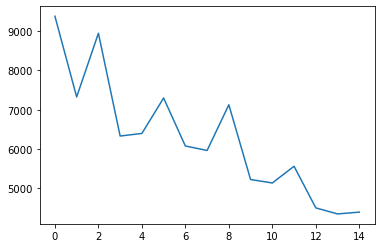

In [99]:
plt.plot(x,loss_val)

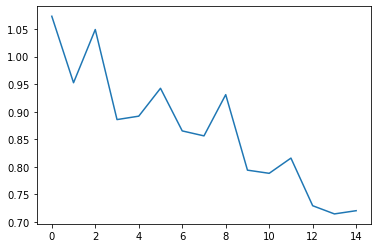

In [100]:
plt.plot(x,train_score)

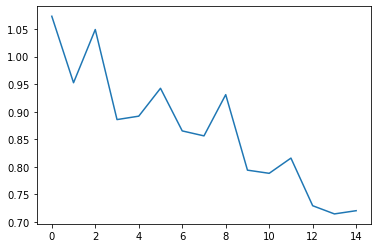

In [101]:
plt.plot(x,val_score)

In [102]:
model.RMSE_score(tr_grade)

0.7204872699371734

# 得到交替最小二乘法下的结果并在训练集上验证

In [157]:
x1,loss_val1,train_score1,val_score1 = model.als_fit()

In [158]:
model.RMSE_score(tr_grade)

0.14840797049950902

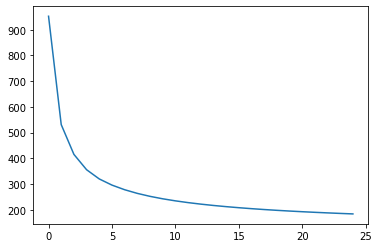

In [160]:
plt.plot(x1,loss_val1)

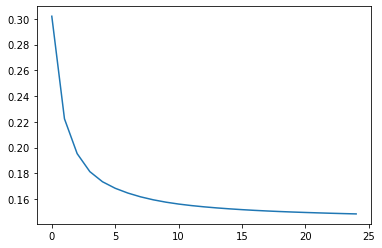

In [161]:
plt.plot(x1,train_score1)

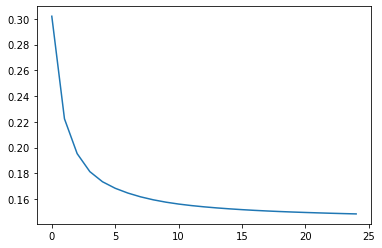

In [162]:
plt.plot(x1,val_score1)

# 在测试集上得到结果

In [163]:
ans = model.pred(df_test)

In [164]:
info = clearinfo(train_filepath,test_filepath)
df_test  = info.getinfo_test()
df_test.drop('date',axis=1,inplace=True)
df_test['stars'] = ans

In [165]:
df_test

,user_id,business_id,stars
0,PfpRvMAESbC2bC8FUIMdNg,Kbbm6Vd5UdbP10dwjBghRw,5.379854
1,oaaEXgQ3x51cXE3GTXrT1Q,2GmGT-7QjowR1ihup3FbVA,1.043902
2,yT_QCcnq-QGipWWuzIpvtw,pOEL97ld-FJMKO8Ki8JmYg,3.314931
3,fRVNHAl2RjosC67Y67G3cA,UkWme3kwg6L9rd4tCNB15w,2.902897
4,48vRThjhuhiSQINQ2KV8Sw,LNGBEEelQx4zbfWnlc66cw,3.864418
...,...,...,...
1957,UL5K2rnSYIPD1LcqPgbmDQ,CauQnqZ5eowyrr7oWF_p3Q,-0.410740
1958,C4OkiPljZ3z2XUa7onmihQ,GI-CAiZ_Gg3h21PwrANB4Q,3.028617
1959,N3oNEwh0qgPqPP3Em6wJXw,2UgRg5a6KmpbD_SZfhNrKg,3.429392
1960,xAWA2aheTP6YwcFWgmeLaQ,f-2pMptlB6cWaWnU7zYE_A,2.774946


In [167]:
df_test.to_csv("answer_ALS.csv")